# Relax Inc. Take Home challenge
*Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven­day period, identify which factors predict future user adoption.*

In [26]:
import pandas as pd

We'll import the datasets using pandas `read_csv` method. The `takehome_users.csv` file appears to be in a difference encoding, so let's confirm what it is before we try to decode it and then pass the correct encoding in. We'll get an error if we don't have the right encoding.

In [27]:
!file -I takehome_users.csv
!file -I takehome_user_engagement.csv

takehome_users.csv: text/plain; charset=iso-8859-1
takehome_user_engagement.csv: text/plain; charset=us-ascii


In [28]:
user_df = pd.read_csv('takehome_users.csv', encoding = "ISO-8859-1")

In [29]:
user_df.head(5)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [30]:
user_engagement_df = pd.read_csv('takehome_user_engagement.csv', parse_dates=True)

In [31]:
user_engagement_df.head(5)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [32]:
user_engagement_df.drop('visited', axis=1, inplace=True)
user_engagement_df['time_stamp'] = pd.to_datetime(user_engagement_df['time_stamp'])

Looks like both tables are ready to be analysed. We'll need to create a column which identifies whether or not the user is an "adopted user" as defined by the brief.

To be an adopted user, they will need to have logged in on three separate days in at least one seven day period. 

If they've only logged in once, then they won't be an adopted user. They'll need to have logged in a minimum of 3 times to be considered adopted, and even those times will have to be within a 7 day window.

Let's create a function which checks if a user is an adopted user:

In [33]:
def is_within_week(differences):
    return all(diff >= 1 and diff <= 7 for diff in differences)
    
    
def is_user_adopted(logins):
    if len(logins) < 3:
        return False
    for a,b,c in zip(logins['time_stamp'][:-1], logins['time_stamp'][1:], logins['time_stamp'][2:]):
        diff_a_b = (b-a).days
        diff_a_c = (c-a).days
        diff_b_c = (c-b).days
        return is_within_week([diff_a_b, diff_a_c, diff_b_c])

In [34]:
is_adopted = user_engagement_df.sort_values(
    ['user_id','time_stamp']).groupby('user_id').apply(is_user_adopted)

In [35]:
is_adopted = is_adopted.rename("is_adopted")
is_adopted.value_counts()

False    8577
True      246
Name: is_adopted, dtype: int64

We now know whether each user is 'adopted' or not. Let's update the user dataframe with this information.

In [36]:
df_with_adopted_metric = user_df.merge(is_adopted, left_on='object_id', right_on='user_id', how='outer').fillna(False)
df_with_adopted_metric.head(5)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,is_adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.39814e+09,1,0,11,10803,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.39624e+09,0,0,1,316,False
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.36373e+09,0,0,94,1525,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.36921e+09,0,0,1,5151,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.35885e+09,0,0,193,5240,False


We can now look at different ways to predict whether a user will be 'adopted' or not.
We'll need to do some data cleaning and feature engineering first, such as removing variables like emails that we won't care about and one hot encoding the categorical variables:

In [37]:
df_with_adopted_metric = pd.concat([pd.get_dummies(df_with_adopted_metric['creation_source'], prefix='creation_source'),
          df_with_adopted_metric
          ],
          axis=1)


In [38]:
df_with_adopted_metric.drop(['name', 'object_id', 'email', 'creation_time', 'last_session_creation_time', 'creation_source'], axis=1, inplace=True)

Let's convert our adopted column to integers for easier modelling:

In [39]:
df_with_adopted_metric.is_adopted = df_with_adopted_metric.is_adopted.astype(int)

We don't really care about the id of the user who invited a particular user, but we do care that they were invited by another user, as this may have an effect of them becoming adopted. Let's create a new column `was_invited` that represents this, and remove `invited_by_user_id`.

In [40]:
df_with_adopted_metric['invited_by_user_id'].value_counts()

False      5583
10741.0      13
2527.0       12
2308.0       11
11770.0      11
           ... 
6313.0        1
2218.0        1
2219.0        1
3043.0        1
11067.0       1
Name: invited_by_user_id, Length: 2565, dtype: int64

In [41]:
df_with_adopted_metric['was_invited'] = (df_with_adopted_metric['invited_by_user_id'] > 0).astype(int)
df_with_adopted_metric.drop('invited_by_user_id', axis=1, inplace=True)

In [42]:
df_with_adopted_metric

,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,is_adopted,was_invited
0,1,0,0,0,0,1,0,11,0,1
1,0,1,0,0,0,0,0,1,0,1
2,0,1,0,0,0,0,0,94,0,1
3,1,0,0,0,0,0,0,1,0,1
4,1,0,0,0,0,0,0,193,0,1
...,...,...,...,...,...,...,...,...,...,...
11995,0,1,0,0,0,0,0,89,0,1
11996,0,0,0,0,1,0,0,200,0,0
11997,1,0,0,0,0,1,1,83,0,1
11998,0,0,1,0,0,0,0,6,0,0


Let's now create training and test splits:

In [43]:
from sklearn.model_selection import train_test_split

y = df_with_adopted_metric['is_adopted']
X = df_with_adopted_metric.drop('is_adopted', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

print("Subset sizes:")
print("Training:", len(X_train))
print("Testing:", len(X_test))

Subset sizes:
Training: 9600
Testing: 2400


Note that we have a severe imbalance in the dataset:

In [44]:
y_train.value_counts()

0    9409
1     191
Name: is_adopted, dtype: int64

Let's perform some sampling methods to get a better balance. Ideally we'd want to experiment with different sampling methods here.

In [51]:
from imblearn.combine import SMOTETomek
X_resampled, y_resampled = SMOTETomek().fit_resample(X_train, y_train)
y_resampled.value_counts()


1    9406
0    9406
Name: is_adopted, dtype: int64

We can now create a model. Let's use a Decision Tree Classifier, as this will allow us to easily see what features are being split on. We'll use Grid Search Cross Validation to ensure that we're selecting the right hyperparameters.

In [62]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

param_test2 = {
    'max_depth': range(1,16,2), 
    'min_samples_split':range(200,1001,200)
}

classifier = GridSearchCV(GradientBoostingClassifier(), param_test2, scoring='f1',verbose=2)

classifier.fit(X_resampled, y_resampled)

print(classifier.best_params_)
print(classifier.best_score_)

y_true, y_pred = y_test, classifier.predict(X_test)
print(classification_report(y_true, y_pred))

print(confusion_matrix(y_true, y_pred))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] max_depth=1, min_samples_split=200 ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............... max_depth=1, min_samples_split=200, total=   0.3s
[CV] max_depth=1, min_samples_split=200 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ............... max_depth=1, min_samples_split=200, total=   0.3s
[CV] max_depth=1, min_samples_split=200 ..............................
[CV] ............... max_depth=1, min_samples_split=200, total=   0.3s
[CV] max_depth=1, min_samples_split=200 ..............................
[CV] ............... max_depth=1, min_samples_split=200, total=   0.4s
[CV] max_depth=1, min_samples_split=200 ..............................
[CV] ............... max_depth=1, min_samples_split=200, total=   0.4s
[CV] max_depth=1, min_samples_split=400 ..............................
[CV] ............... max_depth=1, min_samples_split=400, total=   0.3s
[CV] max_depth=1, min_samples_split=400 ..............................
[CV] ............... max_depth=1, min_samples_split=400, total=   0.3s
[CV] max_depth=1, min_samples_split=400 ..............................
[CV] ............... max_depth=1, min_samples_split=400, total=   0.3s
[CV] max_depth=1, min_samples_split=400 ..............................
[CV] .

[CV] ............... max_depth=5, min_samples_split=400, total=   0.9s
[CV] max_depth=5, min_samples_split=600 ..............................
[CV] ............... max_depth=5, min_samples_split=600, total=   0.8s
[CV] max_depth=5, min_samples_split=600 ..............................
[CV] ............... max_depth=5, min_samples_split=600, total=   0.8s
[CV] max_depth=5, min_samples_split=600 ..............................
[CV] ............... max_depth=5, min_samples_split=600, total=   0.8s
[CV] max_depth=5, min_samples_split=600 ..............................
[CV] ............... max_depth=5, min_samples_split=600, total=   0.8s
[CV] max_depth=5, min_samples_split=600 ..............................
[CV] ............... max_depth=5, min_samples_split=600, total=   0.9s
[CV] max_depth=5, min_samples_split=800 ..............................
[CV] ............... max_depth=5, min_samples_split=800, total=   0.9s
[CV] max_depth=5, min_samples_split=800 ..............................
[CV] .

[CV] ............... max_depth=9, min_samples_split=800, total=   1.2s
[CV] max_depth=9, min_samples_split=800 ..............................
[CV] ............... max_depth=9, min_samples_split=800, total=   1.2s
[CV] max_depth=9, min_samples_split=800 ..............................
[CV] ............... max_depth=9, min_samples_split=800, total=   1.2s
[CV] max_depth=9, min_samples_split=1000 .............................
[CV] .............. max_depth=9, min_samples_split=1000, total=   1.1s
[CV] max_depth=9, min_samples_split=1000 .............................
[CV] .............. max_depth=9, min_samples_split=1000, total=   1.1s
[CV] max_depth=9, min_samples_split=1000 .............................
[CV] .............. max_depth=9, min_samples_split=1000, total=   1.1s
[CV] max_depth=9, min_samples_split=1000 .............................
[CV] .............. max_depth=9, min_samples_split=1000, total=   1.1s
[CV] max_depth=9, min_samples_split=1000 .............................
[CV] .

[CV] .............. max_depth=15, min_samples_split=200, total=   1.8s
[CV] max_depth=15, min_samples_split=200 .............................
[CV] .............. max_depth=15, min_samples_split=200, total=   1.9s
[CV] max_depth=15, min_samples_split=200 .............................
[CV] .............. max_depth=15, min_samples_split=200, total=   1.9s
[CV] max_depth=15, min_samples_split=200 .............................
[CV] .............. max_depth=15, min_samples_split=200, total=   1.9s
[CV] max_depth=15, min_samples_split=200 .............................
[CV] .............. max_depth=15, min_samples_split=200, total=   2.0s
[CV] max_depth=15, min_samples_split=400 .............................
[CV] .............. max_depth=15, min_samples_split=400, total=   1.8s
[CV] max_depth=15, min_samples_split=400 .............................
[CV] .............. max_depth=15, min_samples_split=400, total=   1.8s
[CV] max_depth=15, min_samples_split=400 .............................
[CV] .

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  3.5min finished


{'max_depth': 15, 'min_samples_split': 400}
0.9395811352705022
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      2345
           1       0.04      0.13      0.06        55

    accuracy                           0.91      2400
   macro avg       0.51      0.53      0.50      2400
weighted avg       0.96      0.91      0.93      2400

[[2169  176]
 [  48    7]]


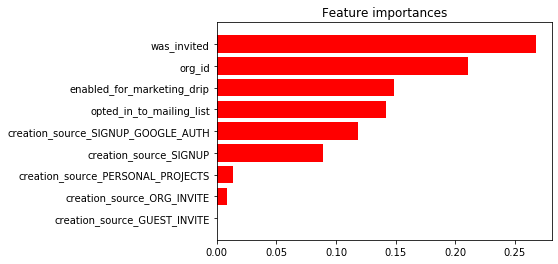

In [71]:
import numpy as np
importances = classifier.best_estimator_.feature_importances_
indices = np.argsort(importances)

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(X.shape[1]), importances[indices],
       color="r", align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(X.shape[1]), X.columns.values)
plt.ylim([-1, X.shape[1]])
plt.show()

From performing gradient boosting above, it's clear that the metric that we defined, `was_invited`, has the largest impact on the algorithm. This could suggest that if a user was invited by another user, i.e. recommended by a friend, then they are likely to stay and become and adopted user. Another interesting factor is whether or not they were opted in for the regular marketing drip - suggesting that regular marketing updates keep users engaged.

It's clear what factors are important to predict future user adoption above. However, this comes from a classifier that isn't always accurate or precise, and therefore we can't be 100% certain that these factors are the most important. It would be useful to try a range of different classification methods, and see whether or not these factors are still relevant. It would also be useful to gather more data, and try out different features.